# Figure 2: detection rates

## Loading the BHNS population

In [12]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tabulate import tabulate
import h5py
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u
import scipy
from scipy import stats
from scipy.integrate import cumtrapz
from scipy.ndimage import gaussian_filter as gf
from matplotlib.lines import Line2D
import pandas
import corner
import sympy as sp
import os
from scipy.interpolate import RegularGridInterpolator
from functions import * 
import sys
sys.path.insert(0, '../COMPAS')
from spin_class import * 

num = 1000000 #number of binaries
eos = "SFHo" #assumed EoS
table = h5py.File('./population_data/bhns_%i_%s_z10_mass_spin_thv_GWFAST.hdf5' %(num,eos),'r') #EM and GW population
mns_max = 2.06 #NS maximum mass for the assumed SFHo EoS

DCOtype='BHNS'
poptype='A'
path = './population_data/COMPASCompactOutput_'+ DCOtype + '_' + poptype+'.h5' #from Broekgaarden+21 

distribution = 'NOT fixed' #or 'fixed' for the same mass distribution at each redshift (approximated redshift evolution)
spin_prescription = 'Zero' #/Qin21/Uniform/Bavera21

### --- Loading Population --- ###

print("Loading intrinsic population")
mbh = table['mbh'][()] #mass of the primary component
mns = table['mns'][()] #mass of the secondary component
lamb_ns = table['lamb_ns'][()] #NS deformability
spin_bh = table['spin_bh'][()] #BH spin
i_tilt = table['i_tilt'][()] #angle between spin and angular momentum 
z = table['z'][()] #redshift
dL = table['dL'][()] #luminosity distance
thv = table['thv'][()] #viewing angle
ra = table['ra'][()]
dec = table['dec'][()]
m_dyn = table['m_dyn'][()] #dynamical ejecta mass
v_dyn = table['v_dyn'][()] #dynamical ejecta velocity
m_disk = table['m_disk'][()] #disk mass
m_out = table['m_out'][()] #ejected mass
final_x = table['final_x'][()] #final spin
E_bkt = table['E_bkt'][()] #brekout energy
E_k_jet = table['E_k_jet'][()] #jet kinetic energy
Ec = table['Ec'][()] #jet core energy

print("Loading GW population")
snr_LVKO4_duty = table['snr_LVKO4_duty'][()] #SNRs LVK O4
snr_LVKIO5_duty = table['snr_LVKIO5_duty'][()] #SNRs LVKI O5

print("Loading EM population (kilonova)")
kn_waves = table['kn_waves'][()] #KN bands = g, z, J
t_kn = table['t_kn'][()] #KN time
lc_kn = table['lc_kn'][()] #KN abs mag

print("Loading EM population (GRB afterglow)")
grb_nu = table['grb_nu'][()] #GRB afterglow bands
t_grb = table['t_grb'][()] #GRB afterglow time
lc_grb = table['lc_grb'][()] #GRB afterglow flux

print("Loading EM population (GRB prompt)")
prompt_band = table['prompt_band'][()] #GRB prompt bands
flux_prompt = table['flux_prompt'][()] #GRB prompt photon flux

table.close()

Loading intrinsic population
Loading GW population
Loading EM population (kilonova)
Loading EM population (GRB afterglow)
Loading EM population (GRB prompt)


## Weighing the BHNS population

In [13]:
if poptype == 'A':
    w_type='w_000' #Only for the fixed population
    r0 = 149 
    w_type_high = 'w_000' #Only for the fixed population
    r0_high = 302 
    w_type_low = 'w_000' #Only for the fixed population
    r0_low = 62
    
spin = calculate_spin_olderCOMPASdata(data_path=path)
if spin_prescription == 'Bavera21':
    spinM1, spinM2  = spin.Bavera21()
if spin_prescription == 'Qin21':
    spinM1, spinM2  = spin.Qin21()
if spin_prescription == 'Uniform':
    spinM1, spinM2  = spin.Bavera21()
    spinM1 = np.random.uniform(0.,0.5,spinM1.shape)
    spinM2 = np.random.uniform(0.,0.5,spinM2.shape)
elif spin_prescription == 'Zero':
    spinM1, spinM2  = spin.Bavera21()
    spinM1 = np.random.uniform(0.,0.,spinM1.shape)
    spinM2 = np.random.uniform(0.,0.,spinM2.shape)

bhx=[2.5,27]
nsx=[1.1,3]
spinx=[0.,1.]
binsx=50
binsy=50
binsz=50
    
if distribution == 'fixed':
    C_mc, w = f_weights_fixed(mbh,mns,thv,spin_bh,z,r0,5.e-2,path,w_type,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)    
    C_mc_low, w_low = f_weights_fixed(mbh,mns,thv,spin_bh,z,r0_low,5.e-2,path,w_type_low,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)
    C_mc_high, w_high = f_weights_fixed(mbh,mns,thv,spin_bh,z,r0_high,5.e-2,path,w_type_high,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)
 
if distribution == 'NOT fixed':
    C_mc, w = f_weights(mbh,mns,thv,spin_bh,z,r0,path,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)
    C_mc_low, w_low = f_weights(mbh,mns,thv,spin_bh,z,r0_low,path,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)
    C_mc_high, w_high = f_weights(mbh,mns,thv,spin_bh,z,r0_high,path,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)

print("")
print("EoS:",eos)
print("Population model:",poptype)
print("The mass and spin distributions are", distribution)
if distribution == 'fixed':
    print("The fiducial SFRD is", w_type, "with r0 =", r0)
    print("The higher limit SFRD is", w_type_high, "with r0 =", r0_high)
    print("The lower limit SFRD is", w_type_low, "with r0 =", r0_low)
print("The spin prescription is:", spin_prescription)
print("")

Computing weights
Computing weights
Computing weights

EoS: SFHo
Population model: A
The mass and spin distributions are NOT fixed
The spin prescription is: Zero



## Detectability conditions

We consider two representative sets of detection limits based on the typical depth that can be reached during an EM follow up in response to a GW alert. For each binary we evaluate if it is GW-, KN-, GRB afterglow- and GRB prompt-detectable.

In [15]:
### --- Limiting Thresholds --- ###
print("O4 detection limits")

lim_snr = 12.
lim_snr_sub = 6.

lim_kn = np.array([22.,22.,21.]) #22 22 21

lim_grb = np.asarray([0.1,5.7e-3,1.5e-6])

lim_prompt_fermi = 4.
lim_prompt_swift = 3.5

#GW
snr_O4 = snr_LVKO4_duty
gw_det_O4 = snr_O4 >= lim_snr
gw_det_O4_sub = snr_O4 >= lim_snr_sub

snr_O5 = snr_LVKIO5_duty
gw_det_O5 = snr_O5 >= lim_snr

#KILONOVA
print("Computing KN limiting thresholds")
kn_peak = np.min(lc_kn, axis=2)
kn_det = np.zeros([num,len(kn_waves)],dtype=bool)
for j in range(len(kn_waves)):
    kn_peak_APP = abs_to_app(kn_peak[:,j],dL[:]*1.e6)
    kn_det[:,j] = kn_peak_APP <= lim_kn[j]
kn_det_all = np.max(kn_det, axis = 1)
kn_det_g = kn_det[:,0]
kn_det_z = kn_det[:,1]
kn_det_J = kn_det[:,2]

#GRB AFTERGLOW
print("Computing GRB AFTERGLOW limiting thresholds")
grb_peak = np.max(lc_grb, axis=2)
grb_det = np.zeros([num,len(grb_nu)],dtype=bool)
grb_det_15 = np.zeros([num,len(grb_nu)],dtype=bool)
for j in range(len(grb_nu)):
    grb_det[:,j] = grb_peak[:,j,0] >= lim_grb[j]
    grb_det_15[:,j] = grb_peak[:,j,1] >= lim_grb[j]
grb_det_all = np.max(grb_det, axis = 1)
grb_det_radio = grb_det[:,0]
grb_det_optic = grb_det[:,1]
grb_det_x = grb_det[:,2]
grb_det_radio_15 = grb_det_15[:,0]
grb_det_optic_15 = grb_det_15[:,1]
grb_det_x_15 = grb_det_15[:,2]
grb_det_all_15 = np.max(grb_det_15, axis = 1)

#GRB PROMPT
print("Computing GRB PROMPT limiting thresholds")
prompt_det_fermi = flux_prompt[:,0,0] >= lim_prompt_fermi
prompt_det_fermi_15 = flux_prompt[:,0,1] >= lim_prompt_fermi
prompt_det_swift = flux_prompt[:,1,0] >= lim_prompt_swift
prompt_det_swift_15 = flux_prompt[:,1,1] >= lim_prompt_swift 

print("O5 detection limits")

lim_snr_O5 = 12

lim_kn_O5 = np.array([26.,24.4,21.])

lim_grb_O5 = np.asarray([1.e-2,1.5e-4,1.5e-6])

lim_prompt_fermi_O5 = 4.
lim_prompt_swift_O5 = 3.5

#KILONOVA
print("Computing KN limiting thresholds")
kn_peak = np.min(lc_kn, axis=2)
kn_det_O5 = np.zeros([num,len(kn_waves)],dtype=bool)
for j in range(len(kn_waves)):
    kn_peak_APP = abs_to_app(kn_peak[:,j],dL[:]*1.e6)
    kn_det_O5[:,j] = kn_peak_APP <= lim_kn_O5[j]
kn_det_all_O5 = np.max(kn_det_O5, axis = 1)
kn_det_g_O5 = kn_det_O5[:,0]
kn_det_z_O5 = kn_det_O5[:,1]
kn_det_J_O5 = kn_det_O5[:,2]

#GRB AFTERGLOW
print("Computing GRB AFTERGLOW limiting thresholds")
grb_peak = np.max(lc_grb, axis=2)
grb_det_O5 = np.zeros([num,len(grb_nu)],dtype=bool)
grb_det_O5_15 = np.zeros([num,len(grb_nu)],dtype=bool)
for j in range(len(grb_nu)):
    grb_det_O5[:,j] = grb_peak[:,j,0] >= lim_grb_O5[j]
    grb_det_O5_15[:,j] = grb_peak[:,j,1] >= lim_grb_O5[j]
grb_det_all_O5 = np.max(grb_det_O5, axis = 1)
grb_det_radio_O5 = grb_det_O5[:,0]
grb_det_optic_O5 = grb_det_O5[:,1]
grb_det_x_O5 = grb_det_O5[:,2]
grb_det_radio_O5_15 = grb_det_O5_15[:,0]
grb_det_optic_O5_15 = grb_det_O5_15[:,1]
grb_det_x_O5_15 = grb_det_O5_15[:,2]

#GRB PROMPT
print("Computing GRB PROMPT limiting thresholds")
prompt_det_fermi_O5 = flux_prompt[:,0,0] >= lim_prompt_fermi_O5
prompt_det_fermi_O5_15 = flux_prompt[:,0,1] >= lim_prompt_fermi_O5
prompt_det_swift_O5 = flux_prompt[:,0,0] >= lim_prompt_swift_O5
prompt_det_swift_O5_15 = flux_prompt[:,0,1] >= lim_prompt_swift_O5

O4 detection limits
Computing KN limiting thresholds
Computing GRB AFTERGLOW limiting thresholds
Computing GRB PROMPT limiting thresholds
O5 detection limits
Computing KN limiting thresholds
Computing GRB AFTERGLOW limiting thresholds
Computing GRB PROMPT limiting thresholds


## Detection rates

In [17]:
x = np.sort(z)
s = np.argsort(z)

### --- Computing detection Rates in O4--- ###

#ALL NSNS
cum_tot = C_mc*np.cumsum(w[s])
cum_tot_high = C_mc_high*np.cumsum(w_high[s])
cum_tot_low = C_mc_low*np.cumsum(w_low[s])

#GW O4
cum_gw_O4 = C_mc*np.cumsum(w[s]*gw_det_O4[s])
cum_gw_O4_high = C_mc_high*np.cumsum(w_high[s]*gw_det_O4[s])
cum_gw_O4_low = C_mc_low*np.cumsum(w_low[s]*gw_det_O4[s])
cum_gw_O4_norm = cum_gw_O4/cum_gw_O4[-1]

#KN O4
cum_gw_kn = C_mc*np.cumsum(w[s]*kn_det_all[s]*gw_det_O4[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_high = C_mc_high*np.cumsum(w_high[s]*kn_det_all[s]*gw_det_O4[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_low = C_mc_low*np.cumsum(w_low[s]*kn_det_all[s]*gw_det_O4[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_g = C_mc*np.cumsum(w[s]*kn_det_g[s]*gw_det_O4[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_g_high = C_mc_high*np.cumsum(w_high[s]*kn_det_g[s]*gw_det_O4[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_g_low = C_mc_low*np.cumsum(w_low[s]*kn_det_g[s]*gw_det_O4[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_z = C_mc*np.cumsum(w[s]*kn_det_z[s]*gw_det_O4[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_z_high = C_mc_high*np.cumsum(w_high[s]*kn_det_z[s]*gw_det_O4[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_z_low = C_mc_low*np.cumsum(w_low[s]*kn_det_z[s]*gw_det_O4[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_J = C_mc*np.cumsum(w[s]*kn_det_J[s]*gw_det_O4[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_J_high = C_mc_high*np.cumsum(w_high[s]*kn_det_J[s]*gw_det_O4[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_J_low = C_mc_low*np.cumsum(w_low[s]*kn_det_J[s]*gw_det_O4[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_g_norm = cum_gw_kn_g/cum_gw_kn_g[-1]

#GRB AFTERGLOW O4
cum_gw_grb =  C_mc*np.cumsum(w[s]*grb_det_all[s]*gw_det_O4[s])
cum_gw_grb_15 =  C_mc*np.cumsum(w[s]*grb_det_all_15[s]*gw_det_O4[s])
cum_gw_grb_high =  C_mc_high*np.cumsum(w_high[s]*grb_det_all[s]*gw_det_O4[s])
cum_gw_grb_low =  C_mc_low*np.cumsum(w_low[s]*grb_det_all[s]*gw_det_O4[s])
cum_gw_grb_radio =  C_mc*np.cumsum(w[s]*grb_det_radio[s]*gw_det_O4[s])  
cum_gw_grb_radio_high =  C_mc_high*np.cumsum(w_high[s]*grb_det_radio[s]*gw_det_O4[s])
cum_gw_grb_radio_low =  C_mc_low*np.cumsum(w_low[s]*grb_det_radio[s]*gw_det_O4[s])  
cum_gw_grb_radio_15 =  C_mc*np.cumsum(w[s]*grb_det_radio_15[s]*gw_det_O4[s])  
cum_gw_grb_radio_high_15 =  C_mc_high*np.cumsum(w_high[s]*grb_det_radio_15[s]*gw_det_O4[s])
cum_gw_grb_radio_low_15 =  C_mc_low*np.cumsum(w_low[s]*grb_det_radio_15[s]*gw_det_O4[s])  
cum_gw_grb_optic =  C_mc*np.cumsum(w[s]*grb_det_optic[s]*gw_det_O4[s])
cum_gw_grb_optic_high =  C_mc_high*np.cumsum(w_high[s]*grb_det_optic[s]*gw_det_O4[s])
cum_gw_grb_optic_low =  C_mc_low*np.cumsum(w_low[s]*grb_det_optic[s]*gw_det_O4[s])
cum_gw_grb_optic_15 =  C_mc*np.cumsum(w[s]*grb_det_optic_15[s]*gw_det_O4[s])
cum_gw_grb_optic_high_15 =  C_mc_high*np.cumsum(w_high[s]*grb_det_optic_15[s]*gw_det_O4[s])
cum_gw_grb_optic_low_15 =  C_mc_low*np.cumsum(w_low[s]*grb_det_optic_15[s]*gw_det_O4[s])
cum_gw_grb_x =  C_mc*np.cumsum(w[s]*grb_det_x[s]*gw_det_O4[s])   
cum_gw_grb_x_high =  C_mc_high*np.cumsum(w_high[s]*grb_det_x[s]*gw_det_O4[s])
cum_gw_grb_x_low =  C_mc_low*np.cumsum(w_low[s]*grb_det_x[s]*gw_det_O4[s])
cum_gw_grb_x_15 =  C_mc*np.cumsum(w[s]*grb_det_x_15[s]*gw_det_O4[s])   
cum_gw_grb_x_high_15 =  C_mc_high*np.cumsum(w_high[s]*grb_det_x_15[s]*gw_det_O4[s])
cum_gw_grb_x_low_15 =  C_mc_low*np.cumsum(w_low[s]*grb_det_x_15[s]*gw_det_O4[s])
cum_gw_grb_radio_norm = cum_gw_grb_radio/cum_gw_grb_radio[-1]
    
#GRB PROMPT O4
cum_gw_fermi = C_mc*np.cumsum(w[s]*prompt_det_fermi[s]*gw_det_O4[s])
cum_gw_fermi_15 = C_mc*np.cumsum(w[s]*prompt_det_fermi_15[s]*gw_det_O4[s])
cum_gw_fermi_high = C_mc_high*np.cumsum(w_high[s]*prompt_det_fermi[s]*gw_det_O4[s])
cum_gw_fermi_low = C_mc_low*np.cumsum(w_low[s]*prompt_det_fermi[s]*gw_det_O4[s])
cum_gw_fermi_high_15 = C_mc_high*np.cumsum(w_high[s]*prompt_det_fermi_15[s]*gw_det_O4[s])
cum_gw_fermi_low_15 = C_mc_low*np.cumsum(w_low[s]*prompt_det_fermi_15[s]*gw_det_O4[s])
cum_gw_fermi_sub = C_mc*np.cumsum(w[s]*prompt_det_fermi[s]*gw_det_O4_sub[s])
cum_gw_fermi_norm = cum_gw_fermi/cum_gw_fermi[-1]
cum_gw_swift = C_mc*np.cumsum(w[s]*prompt_det_swift[s]*gw_det_O4[s])
cum_gw_swift_high = C_mc_high*np.cumsum(w_high[s]*prompt_det_swift[s]*gw_det_O4[s])
cum_gw_swift_low = C_mc_low*np.cumsum(w_low[s]*prompt_det_swift[s]*gw_det_O4[s])
cum_gw_swift_15 = C_mc*np.cumsum(w[s]*prompt_det_swift_15[s]*gw_det_O4[s])
cum_gw_swift_high_15 = C_mc_high*np.cumsum(w_high[s]*prompt_det_swift_15[s]*gw_det_O4[s])
cum_gw_swift_low_15 = C_mc_low*np.cumsum(w_low[s]*prompt_det_swift_15[s]*gw_det_O4[s])

### --- Computing detection Rates in O5--- ###

#GW O5
cum_gw_O5 = C_mc*np.cumsum(w[s]*gw_det_O5[s])
cum_gw_small_O5 = C_mc*np.cumsum(w[s]*gw_det_O5[s]*(mbh[s]<5.))
cum_gw_high_O5 = C_mc_high*np.cumsum(w_high[s]*gw_det_O5[s])
cum_gw_low_O5 = C_mc_low*np.cumsum(w_low[s]*gw_det_O5[s])
cum_gw_norm_O5 = cum_gw_O5/cum_gw_O5[-1]

#KN O5
cum_gw_kn_O5 = C_mc*np.cumsum(w[s]*kn_det_all_O5[s]*gw_det_O5[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6)))
cum_gw_kn_high_O5 = C_mc_high*np.cumsum(w_high[s]*kn_det_all_O5[s]*gw_det_O5[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_low_O5 = C_mc_low*np.cumsum(w_low[s]*kn_det_all_O5[s]*gw_det_O5[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6)))  
cum_gw_kn_g_O5 = C_mc*np.cumsum(w[s]*kn_det_g_O5[s]*gw_det_O5[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6)))
cum_gw_kn_g_high_O5 = C_mc_high*np.cumsum(w_high[s]*kn_det_g_O5[s]*gw_det_O5[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_g_low_O5 = C_mc_low*np.cumsum(w_low[s]*kn_det_g_O5[s]*gw_det_O5[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6)))
cum_gw_kn_z_O5 = C_mc*np.cumsum(w[s]*kn_det_z_O5[s]*gw_det_O5[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6)))
cum_gw_kn_z_high_O5 = C_mc_high*np.cumsum(w_high[s]*kn_det_z_O5[s]*gw_det_O5[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_z_low_O5 = C_mc_low*np.cumsum(w_low[s]*kn_det_z_O5[s]*gw_det_O5[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6)))
cum_gw_kn_J_O5 = C_mc*np.cumsum(w[s]*kn_det_J_O5[s]*gw_det_O5[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6)))
cum_gw_kn_J_high_O5 = C_mc_high*np.cumsum(w_high[s]*kn_det_J_O5[s]*gw_det_O5[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_J_low_O5 = C_mc_low*np.cumsum(w_low[s]*kn_det_J_O5[s]*gw_det_O5[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6)))
cum_gw_kn_g_norm_O5 = cum_gw_kn_g_O5/cum_gw_kn_g_O5[-1]

#GRB AFTERGLOW  O5
cum_gw_grb_O5 =  C_mc*np.cumsum(w[s]*grb_det_all_O5[s]*gw_det_O5[s])
cum_gw_grb_radio_O5 =  C_mc*np.cumsum(w[s]*grb_det_radio_O5[s]*gw_det_O5[s])  
cum_gw_grb_radio_high_O5 =  C_mc_high*np.cumsum(w_high[s]*grb_det_radio_O5[s]*gw_det_O5[s])   
cum_gw_grb_radio_low_O5 =  C_mc_low*np.cumsum(w_low[s]*grb_det_radio_O5[s]*gw_det_O5[s]) 
cum_gw_grb_radio_O5_15 =  C_mc*np.cumsum(w[s]*grb_det_radio_O5_15[s]*gw_det_O5[s])  
cum_gw_grb_radio_high_O5_15 =  C_mc_high*np.cumsum(w_high[s]*grb_det_radio_O5_15[s]*gw_det_O5[s])   
cum_gw_grb_radio_low_O5_15 =  C_mc_low*np.cumsum(w_low[s]*grb_det_radio_O5_15[s]*gw_det_O5[s])  
cum_gw_grb_optic_O5 =  C_mc*np.cumsum(w[s]*grb_det_optic_O5[s]*gw_det_O5[s])
cum_gw_grb_optic_high_O5 =  C_mc_high*np.cumsum(w_high[s]*grb_det_optic_O5[s]*gw_det_O5[s])   
cum_gw_grb_optic_low_O5 =  C_mc_low*np.cumsum(w_low[s]*grb_det_optic_O5[s]*gw_det_O5[s])  
cum_gw_grb_optic_O5_15 =  C_mc*np.cumsum(w[s]*grb_det_optic_O5_15[s]*gw_det_O5[s])
cum_gw_grb_optic_high_O5_15 =  C_mc_high*np.cumsum(w_high[s]*grb_det_optic_O5_15[s]*gw_det_O5[s])   
cum_gw_grb_optic_low_O5_15 =  C_mc_low*np.cumsum(w_low[s]*grb_det_optic_O5_15[s]*gw_det_O5[s])   
cum_gw_grb_x_O5 =  C_mc*np.cumsum(w[s]*grb_det_x_O5[s]*gw_det_O5[s])
cum_gw_grb_x_high_O5 =  C_mc_high*np.cumsum(w_high[s]*grb_det_x_O5[s]*gw_det_O5[s])   
cum_gw_grb_x_low_O5 =  C_mc_low*np.cumsum(w_low[s]*grb_det_x_O5[s]*gw_det_O5[s])
cum_gw_grb_x_O5_15 =  C_mc*np.cumsum(w[s]*grb_det_x_O5_15[s]*gw_det_O5[s])
cum_gw_grb_x_high_O5_15 =  C_mc_high*np.cumsum(w_high[s]*grb_det_x_O5_15[s]*gw_det_O5[s])   
cum_gw_grb_x_low_O5_15 =  C_mc_low*np.cumsum(w_low[s]*grb_det_x_O5_15[s]*gw_det_O5[s])
cum_gw_grb_radio_norm_O5 = cum_gw_grb_radio_O5/cum_gw_grb_radio_O5[-1]

#GRB PROMPT O5
cum_gw_fermi_O5 = C_mc*np.cumsum(w[s]*prompt_det_fermi_O5[s]*gw_det_O5[s])
cum_gw_fermi_high_O5= C_mc_high*np.cumsum(w_high[s]*prompt_det_fermi_O5[s]*gw_det_O5[s])
cum_gw_fermi_low_O5 = C_mc_low*np.cumsum(w_low[s]*prompt_det_fermi_O5[s]*gw_det_O5[s])
cum_gw_fermi_O5_15 = C_mc*np.cumsum(w[s]*prompt_det_fermi_O5_15[s]*gw_det_O5[s])
cum_gw_fermi_high_O5_15= C_mc_high*np.cumsum(w_high[s]*prompt_det_fermi_O5_15[s]*gw_det_O5[s])
cum_gw_fermi_low_O5_15 = C_mc_low*np.cumsum(w_low[s]*prompt_det_fermi_O5_15[s]*gw_det_O5[s])
cum_gw_fermi_norm_O5 = cum_gw_fermi_O5/cum_gw_fermi_O5[-1]
cum_gw_swift_O5 = C_mc*np.cumsum(w[s]*prompt_det_fermi_O5[s]*gw_det_O5[s])
cum_gw_swift_high_O5= C_mc_high*np.cumsum(w_high[s]*prompt_det_swift_O5[s]*gw_det_O5[s])
cum_gw_swift_low_O5 = C_mc_low*np.cumsum(w_low[s]*prompt_det_swift_O5[s]*gw_det_O5[s])
cum_gw_swift_O5_15 = C_mc*np.cumsum(w[s]*prompt_det_fermi_O5_15[s]*gw_det_O5[s])
cum_gw_swift_high_O5_15= C_mc_high*np.cumsum(w_high[s]*prompt_det_swift_O5_15[s]*gw_det_O5[s])
cum_gw_swift_low_O5_15 = C_mc_low*np.cumsum(w_low[s]*prompt_det_swift_O5_15[s]*gw_det_O5[s])


Plotting detection rates O4
Plotting detection rates O5


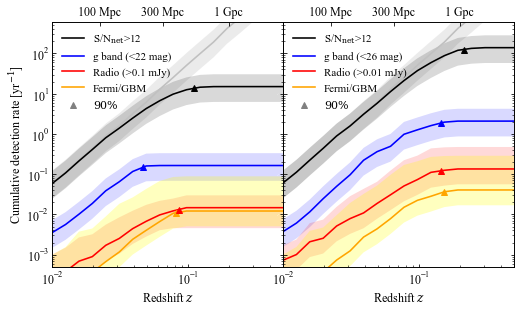

In [20]:

plt.rcParams['font.family']="Times New Roman"
plt.rcParams['figure.figsize']=7.5,4.5
plt.rcParams['mathtext.fontset']='dejavuserif'

gs_kw = dict(width_ratios=[1, 1])
fig1,ax = plt.subplots(1,2,gridspec_kw=gs_kw) 

skip = 30000

### --- Plotting detection rates O4 --- ###

print("Plotting detection rates O4")

ax[0].loglog(x[::skip],cum_tot[::skip],c='silver',linewidth=1.6,zorder=1)
ax[0].fill_between(x[::skip],cum_tot_high[::skip],cum_tot_low[::skip],color='silver',alpha=0.3,edgecolor="None",zorder=1)

ax[0].loglog(x[::skip],cum_gw_O4[::skip],c='black',linestyle='-',linewidth=1.6,zorder=1, label = "S/N$_\mathrm{net}$>12")
ax[0].loglog(x[::skip],cum_gw_kn_g[::skip],c='blue',linewidth=1.6,zorder=1, label="g band (<22 mag)")
ax[0].loglog(x[::skip],cum_gw_grb_radio[::skip],c='red',linewidth=1.6,zorder=1,ls="-",label="Radio (>0.1 mJy)")
ax[0].loglog(x[::skip],cum_gw_fermi[::skip]*0.6,ls="-",c='orange',linewidth=1.6,zorder=1, label="Fermi/GBM")
ax[0].fill_between(x[::skip],cum_gw_O4_high[::skip],cum_gw_O4_low[::skip],color='black',alpha=0.15,edgecolor="None",zorder=1)
ax[0].fill_between(x[::skip],cum_gw_kn_g_high[::skip],cum_gw_kn_g_low[::skip],color='blue',alpha=0.15,edgecolor="None",zorder=1)
ax[0].fill_between(x[::skip],np.maximum(cum_gw_grb_radio_high[::skip],cum_gw_grb_radio_high_15[::skip]),np.minimum(cum_gw_grb_radio_low[::skip],cum_gw_grb_radio_low_15[::skip]),color='red',alpha=0.15,edgecolor="None",zorder=1)
ax[0].fill_between(x[::skip],np.maximum(cum_gw_fermi_high[::skip]*0.6,cum_gw_fermi_high_15[::skip]*0.6),np.minimum(cum_gw_fermi_low[::skip]*0.6,cum_gw_fermi_low_15[::skip]*0.6),color='yellow',alpha=0.25,edgecolor="None",zorder=1)

perc = 0.9
xgw = np.interp(perc,cum_gw_O4_norm[::skip],x[::skip])
ygw = np.interp(np.interp(perc,cum_gw_O4_norm[::skip],x[::skip]),x[::skip],cum_gw_O4[::skip])
xkn = np.interp(perc,cum_gw_kn_g_norm[::skip],x[::skip])
ykn = np.interp(np.interp(perc,cum_gw_kn_g_norm[::skip],x[::skip]),x[::skip],cum_gw_kn_g[::skip])
xfermi = np.interp(perc,cum_gw_fermi_norm[::skip],x[::skip])
yfermi = np.interp(np.interp(perc,cum_gw_fermi_norm[::skip],x[::skip]),x[::skip],cum_gw_fermi[::skip]*0.6)
xgrb = np.interp(perc,cum_gw_grb_radio_norm[::skip],x[::skip])
ygrb = np.interp(np.interp(perc,cum_gw_grb_radio_norm[::skip],x[::skip]),x[::skip],cum_gw_grb_radio[::skip])

ax[0].errorbar(xgw,ygw,c='black',marker='^',elinewidth=1,capsize=2)
ax[0].errorbar(xkn,ykn,c='blue',marker='^',elinewidth=1,capsize=2)
ax[0].errorbar(xfermi,yfermi,ls="-",c='orange',marker='^',elinewidth=1,capsize=2)
ax[0].errorbar(xgrb,ygrb,ls="-",c='red',marker='^',elinewidth=1,capsize=2)
ax[0].errorbar(4,10000000,c='grey',marker='^',linestyle='None',elinewidth=1,capsize=2,label=r"$90\%$")

ylim = (5.e-4,600.)
xlim = (0.01,0.5)

ax[0].legend(loc=2,frameon=False,prop={'size': 11})

ax[0].set_xlabel('Redshift $z$',size=12)
ax[0].set_ylabel(r'Cumulative detection rate [yr$^{-1}$]',size=12)
ax[0].set_ylim(ylim)
ax[0].set_xlim(xlim)
ax[0].set_xticks([0.01,0.1])
ax[0].set_xticklabels(('0.01','0.1'),size=12)
ax[0].minorticks_on()
ax2 = ax[0].twiny()
ax2.set_xlim(xlim)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.minorticks_off()
ax2.set_xticks([0.02225,0.0647,0.198])
ax2.set_xticklabels(('100 Mpc','300 Mpc','1 Gpc'),size=12)

ax[0].tick_params(direction='in',which='both',right=True,labelsize=12,zorder=2)
ax2.tick_params(direction='in',which='both',zorder=2)
ax[0].yaxis.labelpad = 0.1

ax[0].set_yscale('log')
ax[0].set_xscale('log')

### --- Plotting detection rates O5 --- ###

print("Plotting detection rates O5")

ax[1].loglog(x[::skip],cum_tot[::skip],c='silver',linewidth=1.6,zorder=1)
ax[1].loglog(x[::skip],cum_gw_O5[::skip],c='black',linestyle='-',linewidth=1.6,zorder=1,label="S/N$_\mathrm{net}$>12")
ax[1].loglog(x[::skip],cum_gw_kn_g_O5[::skip],c='blue',linewidth=1.6,zorder=1,label="g band (<26 mag)")
ax[1].loglog(x[::skip],cum_gw_grb_radio_O5[::skip],c='red',ls='-',linewidth=1.6,zorder=1,label="Radio (>0.01 mJy)")
ax[1].loglog(x[::skip],cum_gw_fermi_O5[::skip]*0.6,c='orange',ls="-",linewidth=1.6,zorder=1,label="Fermi/GBM")

ax[1].fill_between(x[::skip],cum_tot_high[::skip],cum_tot_low[::skip],color='silver',alpha=0.3,edgecolor="None",zorder=1)
ax[1].fill_between(x[::skip],cum_gw_high_O5[::skip],cum_gw_low_O5[::skip],color='black',alpha=0.15,edgecolor="None",zorder=1)
ax[1].fill_between(x[::skip],cum_gw_kn_g_high_O5[::skip],cum_gw_kn_g_low_O5[::skip],color='blue',alpha=0.15,edgecolor="None",zorder=1)
ax[1].fill_between(x[::skip],np.maximum(cum_gw_grb_radio_high_O5[::skip],cum_gw_grb_radio_high_O5_15[::skip]),np.minimum(cum_gw_grb_radio_low_O5[::skip],cum_gw_grb_radio_low_O5_15[::skip]),color='red',alpha=0.15,edgecolor="None",zorder=1)
ax[1].fill_between(x[::skip],np.maximum(cum_gw_fermi_high_O5[::skip]*0.6,cum_gw_fermi_high_O5_15[::skip]*0.6),np.minimum(cum_gw_fermi_low_O5[::skip]*0.6,cum_gw_fermi_low_O5_15[::skip]*0.6),color='yellow',alpha=0.25,edgecolor="None",zorder=1)

xgw = np.interp(0.9,cum_gw_norm_O5[::skip],x[::skip])
ygw = np.interp(np.interp(0.9,cum_gw_norm_O5[::skip],x[::skip]),x[::skip],cum_gw_O5[::skip])
xkn = np.interp(0.9,cum_gw_kn_g_norm_O5[::skip],x[::skip])
ykn = np.interp(np.interp(0.9,cum_gw_kn_g_norm_O5[::skip],x[::skip]),x[::skip],cum_gw_kn_g_O5[::skip])
xfermi = np.interp(0.9,cum_gw_fermi_norm_O5[::skip],x[::skip])
yfermi = np.interp(np.interp(0.9,cum_gw_fermi_norm_O5[::skip],x[::skip]),x[::skip],cum_gw_fermi_O5[::skip]*0.6)
xgrb = np.interp(0.9,cum_gw_grb_radio_norm_O5[::skip],x[::skip])
ygrb = np.interp(np.interp(0.9,cum_gw_grb_radio_norm_O5[::skip],x[::skip]),x[::skip],cum_gw_grb_radio_O5[::skip])

ax[1].errorbar(xgw,ygw,c='black',marker='^',elinewidth=1,capsize=2)
ax[1].errorbar(xkn,ykn,c='blue',marker='^',elinewidth=1,capsize=2)
ax[1].errorbar(xfermi,yfermi,ls="-",c='orange',marker='^',elinewidth=1,capsize=2)
ax[1].errorbar(xgrb,ygrb,ls="-",c='red',marker='^',elinewidth=1,capsize=2)
ax[1].errorbar(4,10000000,c='grey',marker='^',linestyle='None',elinewidth=1,capsize=2,label=r"$90\%$")


ax[1].legend(loc=2,frameon=False,prop={'size': 11})

ax[1].set_xlabel('Redshift $z$',size=12)
ax[1].set_ylim(ylim)
ax[1].set_xlim(xlim)
ax[1].set_xticks([0.01,0.1])
ax[1].set_xticklabels(('0.01','0.1'),size=12)
ax[1].set_yticks([])
ax[1].tick_params(axis = 'y',direction='in',which='both',right=True,labelsize=0,labelcolor="white",zorder=2)
ax[1].tick_params(axis = 'x',direction='in',which='both',labelsize=12)
ax3 = ax[1].twiny()
ax3.set_xlim(xlim)
ax3.set_xscale('log')
ax3.minorticks_off()
ax3.set_xticks([0.02225,0.0647,0.198])
ax3.set_xticklabels(('100 Mpc','300 Mpc','1 Gpc'),size=12)
fig1.subplots_adjust(wspace=0.,right=0.98)
ax3.tick_params(direction='in',which='both',zorder=2)

ax[1].set_yscale('log')
ax[1].set_xscale('log')

plt.savefig("prova.pdf")
plt.show()

## Kilonova distribution

For the KN we will plot the lightcurves distribution for the O4-detectable binaries in the g and z bands. Then we will add the AT2017gfo data rescaled at the median distance of our population and also the cumulative distribution of the apparent AB magnitude at peak, at 3 and at 5 days after the merger.

/var/folders/db/rmynyr6531s10p7rs_swk3ww0000gn/T/ipykernel_4137/2943952615.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  at2017gfo['e_magnitude'][uplims]=-0.3


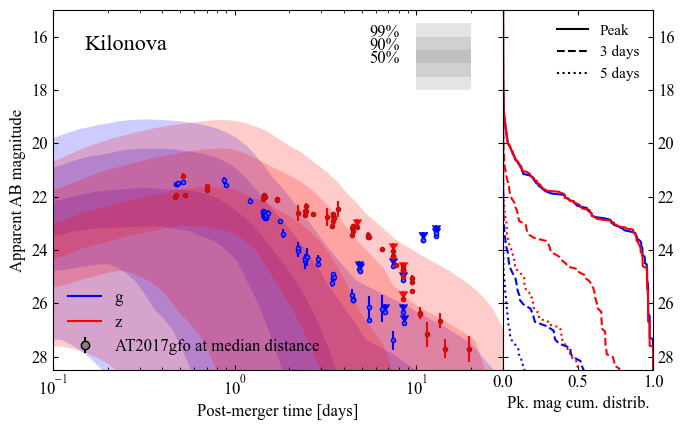

In [18]:
# transform absolute magnitudes to apparent
lc_kn_APP = np.zeros([num,len(kn_waves),len(t_kn)])

for i in range(len(kn_waves)):
    for j in range(len(t_kn)):
        lc_kn_APP[:,i,j] = abs_to_app(lc_kn[:,i,j],dL*1.e6)

mpk_g = np.min(lc_kn_APP[:,0], axis=1)
mpk_z = np.min(lc_kn_APP[:,1], axis=1)
mpk_J = np.min(lc_kn_APP[:,2], axis=1)

mpk_g_3 = np.min(lc_kn_APP[:,0,29:], axis=1)
mpk_z_3 = np.min(lc_kn_APP[:,1,29:], axis=1)
mpk_J_3 = np.min(lc_kn_APP[:,2,29:], axis=1)

mpk_g_5 = np.min(lc_kn_APP[:,0,34:], axis=1)
mpk_z_5 = np.min(lc_kn_APP[:,1,34:], axis=1)
mpk_J_5 = np.min(lc_kn_APP[:,2,34:], axis=1)


# construct confidence regions
perc = [0.01,0.05,0.25,0.5,0.75,0.95,0.99]

conf_curves_g=np.zeros([len(perc),len(t_kn)])
conf_curves_z=np.zeros([len(perc),len(t_kn)])
conf_curves_J=np.zeros([len(perc),len(t_kn)])

gw_det = gw_det_O4
for i in range(len(t_kn)):
    conf_curves_g[:,i]=corner.quantile(lc_kn_APP[:,0,i],perc,weights=w*gw_det*((m_dyn>0.)|(m_disk>0.)))
    conf_curves_z[:,i]=corner.quantile(lc_kn_APP[:,1,i],perc,weights=w*gw_det*((m_dyn>0.)|(m_disk>0.)))
    conf_curves_J[:,i]=corner.quantile(lc_kn_APP[:,2,i],perc,weights=w*gw_det*((m_dyn>0.)|(m_disk>0.)))

# plot confidence curves
kn_bands = ['g','z']
kn_colors = ['blue','red']

left=0.1
bottom=0.14
width=0.6
height=0.8
plt.axes([left,bottom,width,height])

for i,conf in enumerate([conf_curves_g,conf_curves_z]):
    plt.fill_between(t_kn,conf[0],conf[-1],edgecolor='None',facecolor=kn_colors[i],alpha=0.2)
    plt.fill_between(t_kn,conf[1],conf[-2],edgecolor='None',facecolor=kn_colors[i],alpha=0.2)
    plt.fill_between(t_kn,conf[2],conf[-3],edgecolor='None',facecolor=kn_colors[i],alpha=0.2)

if True: # add AT2017gfo for comparison
    ## find median distance
    W = w*gw_det
    s = np.argsort(dL)
    dL_cdf = np.cumsum(W[s])
    dL_cdf/=dL_cdf[-1]
    dL0 = np.sort(dL)
    dL_median = np.interp(0.5,dL_cdf,dL0)
 
    mjd_gw = 57982.5285
    at2017gfo = pandas.read_csv('./AT2017gfo/At2017gfo_photometry.csv')
    dist_mod = 5*np.log10(dL_median/42.)
    zband = at2017gfo['band'].astype(str)=='z'
    gband = at2017gfo['band'].astype(str)=='g'
    Jband = at2017gfo['band'].astype(str)=='J'
    uplims = at2017gfo['upperlimit'].astype(str)=='T'
    at2017gfo['e_magnitude'][uplims]=-0.3
    extinction = {'g':0.4,'z':0.16,'J':0.087} # r: 0.28
    
    plt.errorbar(at2017gfo['time'][gband]-mjd_gw,at2017gfo['magnitude'][gband]+dist_mod-extinction['g'],yerr=np.abs(at2017gfo['e_magnitude'][gband]),markersize=3,markerfacecolor="royalblue",color='blue',ls='None',marker='o',uplims=uplims[gband])
    plt.errorbar(at2017gfo['time'][zband]-mjd_gw,at2017gfo['magnitude'][zband]+dist_mod-extinction['z'],yerr=np.abs(at2017gfo['e_magnitude'][zband]),markersize=3,markeredgecolor='#B11313',color='red',ls='None',marker='o',uplims=uplims[zband])    

plt.errorbar(100,100,yerr=1000,color='black',markerfacecolor="grey",ls='None',label='AT2017gfo at median distance',marker='o')
plt.plot([0.],[0.],color='blue',label='g')
plt.plot([0.],[0.],color='red',label='z')

plt.fill_between([1.e1,2.e1],[18.,18.],[15.5,15.5],color="grey",alpha=0.2,edgecolor=None)
plt.fill_between([1.e1,2.e1],[17.5,17.5],[16.,16.],color="grey",alpha=0.2,edgecolor=None)
plt.fill_between([1.e1,2.e1],[17.,17.],[16.5,16.5],color="grey",alpha=0.2,edgecolor=None)

plt.text(5.5,16.,"99%",size=12)
plt.text(5.5,16.5,"90%",size=12)
plt.text(5.5,17.,"50%",size=12)
plt.text(0.15,16.5,"Kilonova",size=16)

plt.xscale('log')
plt.gca().invert_yaxis()
plt.xlim([1e-1,30.])
plt.ylim([28.5,15.])
plt.xlabel(r'Post-merger time [days]',size=12)
plt.ylabel(r'Apparent AB magnitude',size=12)
plt.tick_params(which='both',direction='in',top=True,right=True,labelsize=12)
plt.legend(loc='lower left',frameon=False,prop={'size': 12})

# construct cumulative peak mag distribution
#np.histogram
s_mpk_g,bins_g,patches = plt.hist(mpk_g,weights=w*gw_det*((m_dyn>0.)|(m_disk>0.)),cumulative=1, density = 1, bins=1000)
s_mpk_z,bins_z,patches = plt.hist(mpk_z,weights=w*gw_det*((m_dyn>0.)|(m_disk>0.)),cumulative=1, density = 1, bins=1000)

bincentre_g = np.zeros(len(bins_g)-1)
bincentre_z = np.zeros(len(bins_z)-1)
for j in range(len(bins_g)-1):
    bincentre_g[j] = bins_g[j] + (bins_g[j+1] - bins_g[j]) / 2.
    bincentre_z[j] = bins_z[j] + (bins_z[j+1] - bins_z[j]) / 2.
    
s_mpk_g_3,bins_g_3,patches = plt.hist(mpk_g_3,weights=w*gw_det*((m_dyn>0.)|(m_disk>0.)),cumulative=1, density = 1, bins=1000)
s_mpk_z_3,bins_z_3,patches = plt.hist(mpk_z_3,weights=w*gw_det*((m_dyn>0.)|(m_disk>0.)),cumulative=1, density = 1, bins=1000)

bincentre_g_3 = np.zeros(len(bins_g_3)-1)
bincentre_z_3 = np.zeros(len(bins_z_3)-1)
for j in range(len(bins_g_3)-1):
    bincentre_g_3[j] = bins_g_3[j] + (bins_g_3[j+1] - bins_g_3[j]) / 2.
    bincentre_z_3[j] = bins_z_3[j] + (bins_z_3[j+1] - bins_z_3[j]) / 2.
    
s_mpk_g_5,bins_g_5,patches = plt.hist(mpk_g_5,weights=w*gw_det*((m_dyn>0.)|(m_disk>0.)),cumulative=1, density = 1, bins=1000)
s_mpk_z_5,bins_z_5,patches = plt.hist(mpk_z_5,weights=w*gw_det*((m_dyn>0.)|(m_disk>0.)),cumulative=1, density = 1, bins=1000)

bincentre_g_5 = np.zeros(len(bins_g_5)-1)
bincentre_z_5 = np.zeros(len(bins_z_5)-1)
for j in range(len(bins_g_5)-1):
    bincentre_g_5[j] = bins_g_5[j] + (bins_g_5[j+1] - bins_g_5[j]) / 2.
    bincentre_z_5[j] = bins_z_5[j] + (bins_z_5[j+1] - bins_z_5[j]) / 2.

# plot cumulative distributions
plt.axes([left+width,bottom,1-left-width-0.1,height])
plt.plot(s_mpk_g,bincentre_g,color=kn_colors[0])
plt.plot(s_mpk_z,bincentre_z,color=kn_colors[1])

plt.plot(s_mpk_g_3,bincentre_g_3,color=kn_colors[0],ls="--")
plt.plot(s_mpk_z_3,bincentre_z_3,color=kn_colors[1],ls="--")

plt.plot(s_mpk_g_5,bincentre_g_5,color=kn_colors[0],ls=":")
plt.plot(s_mpk_z_5,bincentre_z_5,color=kn_colors[1],ls=":")

plt.axvline(10,c='black',ls='-',label='Peak')
plt.axvline(10,c='black',ls='--',label='3 days')
plt.axvline(10,c='black',ls=':',label='5 days')

plt.legend(frameon=False,prop={'size': 11})
plt.ylim([28.5,15.])
plt.xlim([0.,1.])
plt.tick_params(which='both',direction='in',labelleft=False,labelright=True,right=True,top=True,labelsize=12)
plt.xlabel('Pk. mag cum. distrib.',size=12)

plt.show()

## Radio afterglow follow-up strategies

We now focus on the radio afterglow, and ask whether the detecting the KN beforehand has a strong impact on detecting the afterglow. If this is the case, we should motivate tiling radio instruments such as the DSA.

In [19]:
## Here are the instrument characteristics to use for the observing strategies.

# Optical
lsst_fov = 9.6 #* Deg2
ztf_fov = 47.7 #* Deg2
lsst_survey_cadence = 3 # day
ztf_survey_cadence = 1 # day
lsst_tiling_cadence = 1 / 24 # 1h
ztf_tiling_cadence = 1 / 24 # 1h

lsst_d = {'g' : 26.0, # 180 s
'z' : 24.5} # 180 s

lsst_d_min = {'g' : 25.0, # 30 s
'z' : 23.5} # 30 s

growth_d = {'g' : 22, # 90 s
'z' : 20.9, # GROWTH-India, 600 s
'J' : 16, # 65s
           }

# Radio DSA-2000
dsa_tiling_lim = 1.e-3 # miliJy
dsa_tiling_fov = 10.6 # Deg2
dsa_tiling_cadence = 4 / 24 # = 4 hour

dsa_survey_lim = 2.e-3 # miliJy
dsa_survey_fov = 10.6 # Deg2
dsa_survey_cadence = 114 # days

# Radio SKA1
ska1_lim = 2.e-3 # miliJy
ska1_fov = 0.0167 # 60 arcmin2
ska1_cadence = 4 / 24 # = 4 hour


# Radio SKA2
ska2_lim = 2.e-4 # miliJy
ska2_fov = 0.333 # 60 arcmin2
ska2_cadence = 4 / 24 # = 4 hour

# Generic kilonova limits
gen_d = {'g' : 24, # Generic KN limits
'z' : 22.5,
#'J' : 18,
}

In [20]:
# Extract radio afterglow peak times
grb_tpk = np.zeros_like(grb_peak[:,0,0])
grb_tpk_15 = np.zeros_like(grb_peak[:,0,1])

for i in range(len(grb_peak)):
    grb_tpk[i] = t_grb[np.argmax(lc_grb[i, 0, :, 0])]
    grb_tpk_15[i] = t_grb[np.argmax(lc_grb[i, 0, :, 1])]

In [21]:
# Extract duration of afterglow above radio threshold
deltat_ag = np.zeros_like(grb_tpk)
deltat_ag_15 = np.zeros_like(grb_tpk)

for i in range(len(deltat_ag)):
    above_time = t_grb[(lc_grb[i, 0, :, 0] > 0.01)]
    if len(above_time) == 0:
        continue
    if len(above_time) == 1:
        deltat_ag[i] = above_time.max() * (1 - 10**(-0.08163))
    else:
        deltat_ag[i] = above_time.max() - above_time.min()
        
for i in range(len(deltat_ag_15)):
    above_time = t_grb[(lc_grb[i, 0, :, 1] > 0.01)]
    if len(above_time) == 0:
        continue
    if len(above_time) == 1:
        deltat_ag_15[i] = above_time.max() * (1 - 10**(-0.08163))
    else:
        deltat_ag_15[i] = above_time.max() - above_time.min()

### Table 1

In [22]:
# O4, GEN
fil_gw = (snr_O4 > 12)
fil_ag = fil_gw &(m_out>0) & (grb_peak[:,0,1]>0.01)
fil_kn = fil_gw &(m_out>0) & ((mpk_g < gen_d['g']) | (mpk_z < gen_d['z']))
fil_grb = fil_gw & (m_out > 0) & (prompt_det_fermi)

print("O4 + GEN")
print(f"Selection by GW {fil_gw.sum()}, {w[fil_gw].sum()}")
print(f"Selection by GW+KN {fil_kn.sum()}, {w[fil_kn].sum()}")
print(f"Selection by GW+AG {fil_ag.sum()}, {w[fil_ag].sum()}")
print(f"Selection by GW+AG+KN {(fil_ag&fil_kn).sum()}, {w[fil_ag&fil_kn].sum()}")
print(f"Selection by GW+AG-KN {(fil_ag&~fil_kn).sum()}, {w[fil_ag&~fil_kn].sum()}")
print(f"Selection by GW+AG-KN+GRB {(fil_ag&(~fil_kn)&(prompt_det_fermi)).sum()}, {w[fil_ag&(~fil_kn)&(prompt_det_fermi)].sum()}")


O4 + GEN
Selection by GW 377628, 156.23184619097623
Selection by GW+KN 59646, 3.5556717709292767
Selection by GW+AG 49816, 0.6923953335494235
Selection by GW+AG+KN 49698, 0.6923522120717391
Selection by GW+AG-KN 118, 4.312147768430946e-05
Selection by GW+AG-KN+GRB 91, 4.312147768430946e-05


In [23]:
# O5, GEN
fil_gw = (snr_O5 > 12)
fil_ag = fil_gw & (m_out>0) & (grb_peak[:,0,1]>0.01)
fil_kn = fil_gw & (m_out>0) & ((mpk_g < gen_d['g']) | (mpk_z < gen_d['z']))

print("O5 + GEN")
print(f"Selection by GW {fil_gw.sum()}, {w[fil_gw].sum()}")
print(f"Selection by GW+KN {fil_kn.sum()}, {w[fil_kn].sum()}")
print(f"Selection by GW+AG {fil_ag.sum()}, {w[fil_ag].sum()}")
print(f"Selection by GW+AG+KN {(fil_ag&fil_kn).sum()}, {w[fil_ag&fil_kn].sum()}")
print(f"Selection by GW+AG-KN {(fil_ag&~fil_kn).sum()}, {w[fil_ag&~fil_kn].sum()}")
print(f"Selection by GW+AG-KN+GRB {(fil_ag&(~fil_kn)&(prompt_det_fermi)).sum()}, {w[fil_ag&(~fil_kn)&(prompt_det_fermi)].sum()}")


O5 + GEN
Selection by GW 473585, 1308.562946308107
Selection by GW+KN 73376, 13.8136071727653
Selection by GW+AG 59811, 2.7801367508408372
Selection by GW+AG+KN 58579, 1.9144071169573913
Selection by GW+AG-KN 1232, 0.8657296338834458
Selection by GW+AG-KN+GRB 918, 0.39172918106589955


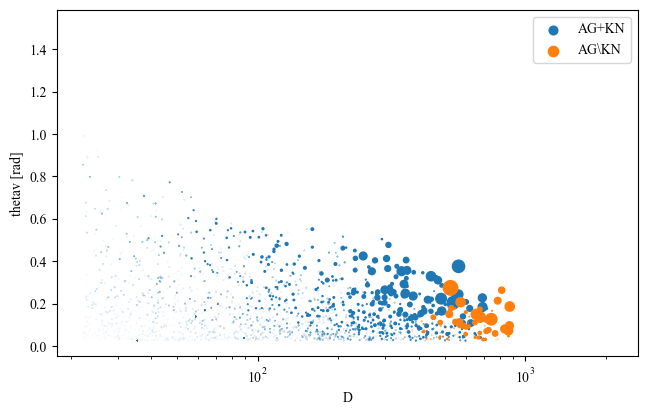

In [27]:
# The AG-det that have neither KN nor GRB detectable are slightly off-axis
X = 10000
w_0 = w[fil_gw].max()

fil = fil_ag&fil_kn
plt.scatter(dL[fil], thv[fil], label='AG+KN', s = X * w[fil]/w_0)
fil = fil_ag&~fil_kn
plt.scatter(dL[fil], thv[fil], label='AG\KN', s = X * w[fil]/w_0)

plt.xlabel('D')
plt.ylabel('thetav [rad]')

plt.xscale('log')
plt.legend()

### Fig. 3

The dots are the events selected by GW + AG +KN (blue) or GW + KN - AG (red). The oblique line is the tiling limit a tiling radio instrument.

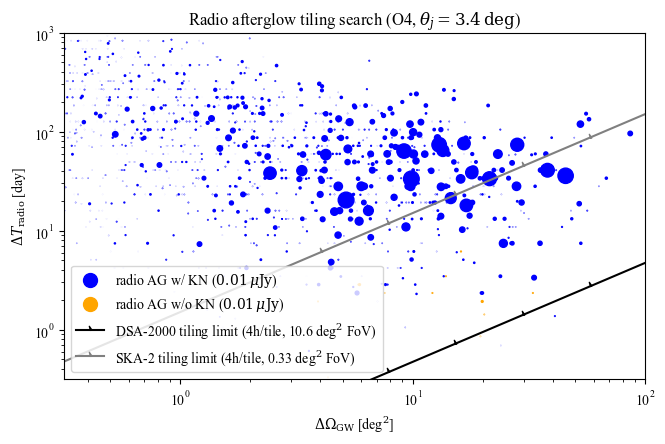

In [30]:
#### Fig. 3 ####

alphapp = 25 * np.pi / 180
rpp = 500
verts=[[0, 0],[rpp*np.cos(alphapp), rpp*np.sin(alphapp)],
       [0.5 * rpp * np.cos(alphapp) - 3 * rpp * np.sin(alphapp),0.5 * rpp * np.sin(alphapp) + 3 * rpp * np.cos(alphapp)],
      [0, 0]]

X = 10000
om_l = 10**np.linspace(-1-1, 2.5+1, 20)
fil_gw = (snr_O4>12)
w_0 = w[fil_gw].max()

# AG with KN
fil = (snr_O4>12)&(m_out>0)&(grb_peak[:,0,0] > 0.01)\
      &((mpk_g< gen_d['g']) | (mpk_z< gen_d['z']))           
plt.scatter(sky_loc_LVKO4[fil], deltat_ag[fil], s = X * w[fil]/w_0, color='blue')
plt.scatter([0], [0], label=r'radio AG w/ KN ($0.01\,\mu{\rm Jy}$)', s = X/100, color='blue')

# AG without KN
fil = (snr_O4>12)&(m_out>0)&(grb_peak[:,0,0] > 0.01)\
      &(~((mpk_g< gen_d['g']) | (mpk_z< gen_d['z'])))     
plt.scatter(sky_loc_LVKO4[fil], deltat_ag[fil], s = X * w[fil]/w_0, color='orange')
plt.scatter([0], [0], label=r'radio AG w/o KN ($0.01\,\mu{\rm Jy}$)', s = X/100, color='orange')

# DSA ans SKA tiling
plt.plot(om_l, 3* dsa_tiling_cadence * om_l / dsa_tiling_fov, color='black', label=r'DSA-2000 tiling limit (4h/tile, 10.6 deg$^2$ FoV)', marker=verts)
plt.plot(om_l, 3* ska2_cadence * om_l / ska2_fov, color='grey', label=r'SKA-2 tiling limit (4h/tile, 0.33 deg$^2$ FoV)', marker=verts)
#plt.text(10**1.1, 10**-0.1, r"$\Delta T_{\rm radio} / t_{\rm cadence} > 3 \times \Delta \Omega_{\rm GW} / {\rm FoV}$", color='black', rotation=24.8)

plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$\Delta T_{\rm radio}$ [day]')
plt.xlabel(r'$\Delta \Omega_{\rm GW}$ [deg$^2$]')

plt.title(r'Radio afterglow tiling search (O4, $\theta_j = 3.4\,{\rm deg}$)')
plt.legend(loc='lower left')
plt.xlim([10**-0.5, 10**2])
plt.ylim([10**-0.5, 10**3])

plt.savefig(f'plots/fig3-O4.pdf', bbox_inches='tight')

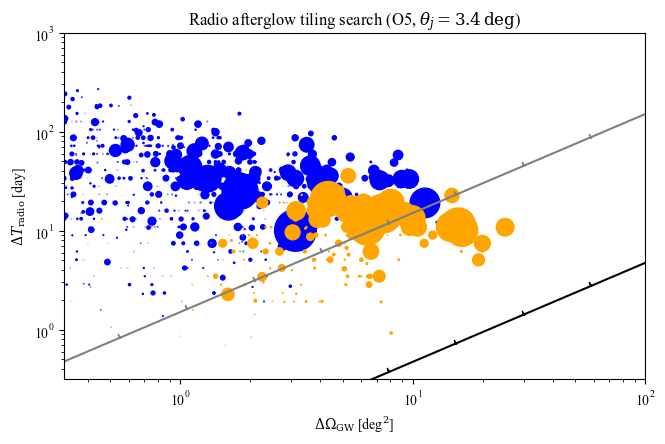

In [31]:
#### Fig. 3 ####
ymin = -1
ymax = 2.5
xmin = 0
xmax = 2.5
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

fil_gw = (snr_O5>12)

# AG
fil = fil_gw&(m_out>0)&(grb_peak[:,0,0] > 0.01)

# AG with KN
fil = fil_gw&(m_out>0)&(grb_peak[:,0,0] > 0.01)\
      &((mpk_g< gen_d['g']) | (mpk_z< gen_d['z']))           
plt.scatter(sky_loc_LVKIO5[fil], deltat_ag[fil], s = X * w[fil]/w_0, color='blue')
plt.scatter([0], [0], label=r'radio AG w/ KN ($0.01\,\mu{\rm Jy}$)', s = X/100, color='blue')

# AG without KN
fil = fil_gw&(m_out>0)&(grb_peak[:,0,0] > 0.01)\
      &(~((mpk_g< gen_d['g']) | (mpk_z< gen_d['z'])))        
plt.scatter(sky_loc_LVKIO5[fil], deltat_ag[fil], s = X * w[fil]/w_0, color='orange')
plt.scatter([0], [0], label=r'radio AG w/o KN ($0.01\,\mu{\rm Jy}$)', s = X/100, color='orange')

# DSA tiling
plt.plot(om_l, 3* dsa_tiling_cadence * om_l / dsa_tiling_fov, color='black', label=r'DSA-2000 tiling limit (4\,h/tile, 10.6 deg$^2$ FoV)', marker=verts)
plt.plot(om_l, 3* ska2_cadence * om_l / ska2_fov, color='grey', label=r'SKA-2 tiling limit (4\,h/tile, 0.33 deg$^2$ FoV)', marker=verts)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$\Delta T_{\rm radio}$ [day]')
plt.xlabel(r'$\Delta \Omega_{\rm GW}$ [deg$^2$]')

plt.title(r'Radio afterglow tiling search (O5, $\theta_j = 3.4\,{\rm deg}$)')
#plt.legend(loc='lower left')
plt.xlim([10**-0.5, 10**2])
plt.ylim([10**-0.5, 10**3])

plt.savefig(f'plots/fig3-O5.pdf', bbox_inches='tight')

## Study of kilonova follow-up strategies

We start by studying the prospects for KN detections in both survey and tiling strategies.

A look on some kilonova light curve examples

Text(0, 0.5, '$m(t) - m(t = t_{\\rm peak})$')

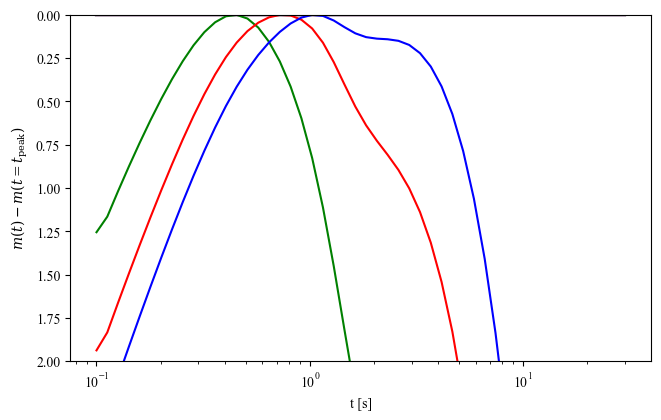

In [16]:
plt.figure()
for i in [2, 4, 6, 8]:
    plt.plot(t_kn, lc_kn_APP[i, 0, :] - mpk_g[i], color='green')
    plt.plot(t_kn, lc_kn_APP[i, 1, :] - mpk_z[i], color='red')
    plt.plot(t_kn, lc_kn_APP[i, 2, :] - mpk_J[i], color='blue')
plt.ylim([2, 0])
plt.xscale('log')
plt.xlabel('t [s]')
plt.ylabel(r'$m(t) - m(t = t_{\rm peak})$')

In [17]:
# Extract kilonova peak times and corresponding indices
indices = np.array(range(len(t_kn)))

itpk_g = np.argmin(lc_kn_APP[:,0], axis=1)
itpk_z = np.argmin(lc_kn_APP[:,1], axis=1)
itpk_J = np.argmin(lc_kn_APP[:,2], axis=1)

tpk_g = t_kn[itpk_g]
tpk_z = t_kn[itpk_z]
tpk_J = t_kn[itpk_J]

# Kilonova decay times from peak (2 magnitudes)
# Since one has to be careful about counting after the peak, I found no smarter way than to do loops...
dt_2_g = np.zeros_like(mpk_g)
for i in range(len(mpk_g)):
    wh = np.where((lc_kn_APP[i,0] > (mpk_g[i] + 2))  & (indices > itpk_g[i]))[0]
    if wh.size == 0:
        dt_2_g[i] = 1.e-42
    else:
        dt_2_g[i] = t_kn[wh.min()] - tpk_g[i]
        
dt_2_z = np.zeros_like(mpk_g)
for i in range(len(mpk_g)):
    wh = np.where((lc_kn_APP[i,1] > (mpk_z[i] + 2))  & (indices > itpk_z[i]))[0]
    if wh.size == 0:
        dt_2_z[i] = 1.e-42
    else:
        dt_2_z[i] = t_kn[wh.min()] - tpk_z[i]
        
dt_2_J = np.zeros_like(mpk_g)
for i in range(len(mpk_g)):
    wh = np.where((lc_kn_APP[i,2] > (mpk_J[i] + 2))  & (indices > itpk_J[i]))[0]
    if wh.size == 0:
        dt_2_J[i] = 1.e-42
    else:
        dt_2_J[i] = t_kn[wh.min()] - tpk_J[i]

### Fig. 1

This plot is to study the survey strategy, i.e., the serendipitous detection of NSBHs that were GW-triggered. This is motivated by the fact that not all GW-triggers will trigger ToO time by LSST.

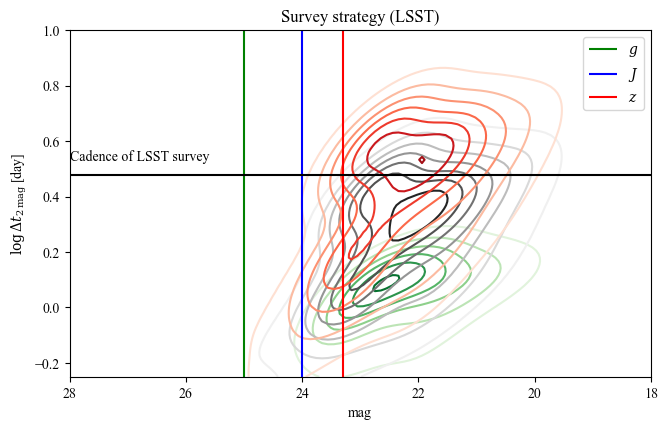

In [19]:
#### Fig. 1####
ymin = -0.25
ymax = 1
xmin = 18
xmax = 28
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

#g
values = np.vstack([mpk_g, np.log10(dt_2_g)])
kernel = st.gaussian_kde(values, bw_method=0.40,weights=w*gw_det_O4*((m_dyn>0.)|(m_disk>0.)))
f = np.reshape(kernel(positions).T, xx.shape)
plt.contour(xx, yy, f, cmap='Greens')

#z
values = np.vstack([mpk_z, np.log10(dt_2_z)])
kernel = st.gaussian_kde(values, bw_method=0.40,weights=w*gw_det_O4*((m_dyn>0.)|(m_disk>0.)))
f = np.reshape(kernel(positions).T, xx.shape)
plt.contour(xx, yy, f, cmap='Greys')

#J
values = np.vstack([mpk_J, np.log10(dt_2_J)])
kernel = st.gaussian_kde(values, bw_method=0.40,weights=w*gw_det_O4*((m_dyn>0.)|(m_disk>0.)))
f = np.reshape(kernel(positions).T, xx.shape)
plt.contour(xx, yy, f, cmap='Reds')

#LSST
plt.vlines(lsst_d['g'], -2, 2, color='green', label='$g$')
plt.vlines(lsst_d['J'], -2, 2, color='blue', label='$J$')
plt.vlines(lsst_d['z'], -2, 2, color='red', label='$z$')
plt.hlines(np.log10(lsst_survey_cadence), 30, 10, color='black')
plt.text(28, np.log10(lsst_survey_cadence) + 0.05, "Cadence of LSST survey")
plt.xlim([xmax, xmin])
plt.ylim([ymin, ymax])
plt.ylabel(r'$\log \Delta t_{\rm 2\,mag}$ [day]')
plt.xlabel('mag')

plt.title('Survey strategy (LSST)')
plt.legend()
#plt.savefig(f'plots/fig1.pdf', bbox_inches='tight')

### Fig. 2

This figure is to study the tiling strategy, which is a search of the GW skymap using tiles. The countour lines show the event selected by the magntiude limits of the instruments, i.e., they are "detectable". The oblique line shows the systems where the GW skymap can be covered at least 3 times within the KN decay timescale.

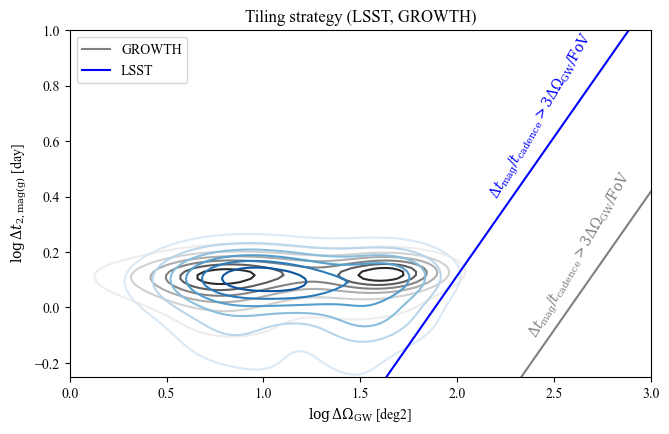

In [111]:
#### Fig. 2 ####
ymin = -0.25
ymax = 1
xmin = 0
xmax = 3
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

om_l = 10**np.linspace(xmin, xmax, 300)

fil =(snr_O4>12)&(m_out>0)

# GROWTH
values = np.vstack([np.log10(sky_loc_LVKO4[fil]), np.log10(dt_2_g[fil])])
kernel = st.gaussian_kde(values, bw_method=0.40,
    weights=w[fil] * ((mpk_g[fil] < growth_d['g']) | (mpk_z[fil] < growth_d['z']) | (mpk_J[fil] < growth_d['J']) ))
f = np.reshape(kernel(positions).T, xx.shape)
plt.contour(xx, yy, f, cmap='Greys')
plt.plot(np.log10(om_l), np.log10(3 * ztf_tiling_cadence * om_l / ztf_fov), color='grey', label='GROWTH')

# ZTF
values = np.vstack([np.log10(sky_loc_LVKO4[fil]), np.log10(dt_2_g[fil])])
kernel = st.gaussian_kde(values, bw_method=0.40,
    weights=w[fil] * ((mpk_g[fil] < lsst_d['g']) | (mpk_z[fil] < lsst_d['z'])))
f = np.reshape(kernel(positions).T, xx.shape)
plt.contour(xx, yy, f, cmap='Blues')
plt.plot(np.log10(om_l), np.log10(3 * lsst_tiling_cadence * om_l / lsst_fov), color='blue', label='LSST')

plt.text(2.15, 0.4, r"$\Delta t_{\rm mag} / t_{\rm cadence} > 3 \Delta \Omega_{\rm GW} / {\rm FoV}$", color='blue', rotation=60)
plt.text(2.35, -0.1, r"$\Delta t_{\rm mag} / t_{\rm cadence} > 3 \Delta \Omega_{\rm GW} / {\rm FoV}$", color='grey', rotation=60)

plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.ylabel(r'$\log \Delta t_{\rm 2, mag (g)}$ [day]')
plt.xlabel(r'$\log \Delta \Omega_{\rm GW}$ [deg2]')

plt.title('Tiling strategy (LSST, GROWTH)')
plt.legend()
#plt.savefig(f'plots/fig2.pdf', bbox_inches='tight')

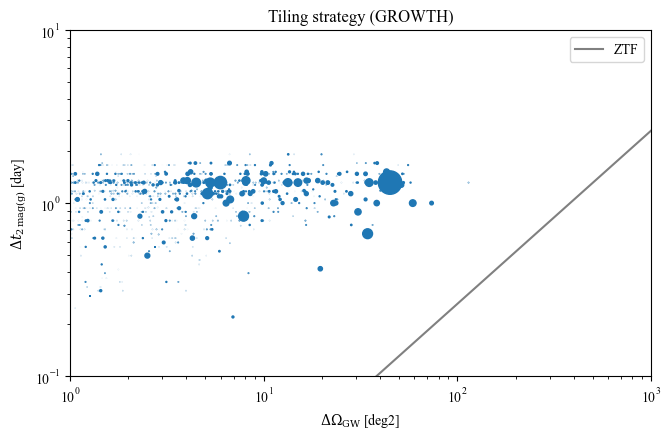

In [362]:
### Here is the same plot in scatter-mode, to show the whole sample of detectable events.
### In this version, one cannot apply the weighting...

#### Fig. 2bis ####
ymin = -0.25
ymax = 1
xmin = 0
xmax = 3
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

om_l = 10**np.linspace(xmin, xmax, 300)

fil = ((snr_O4>12)&(m_out>0) & ((mpk_g < growth_d['g']) | (mpk_z < growth_d['z']) | (mpk_J < growth_d['J']) ))

# ZTF
plt.plot(om_l, 3 * ztf_tiling_cadence * om_l / ztf_fov, color='grey', label='ZTF')
plt.scatter(sky_loc_LVKO4[fil], dt_2_g[fil], s = 1000 * w[fil])
plt.xscale('log')
plt.yscale('log')
plt.xlim([1, 1.e3])
plt.ylim([0.1, 10])
plt.ylabel(r'$\Delta t_{\rm 2\,mag (g)}$ [day]')
plt.xlabel(r'$\Delta \Omega_{\rm GW}$ [deg2]')

plt.title('Tiling strategy (GROWTH)')
plt.legend()
#plt.savefig(f'plots/fig2bis.pdf', bbox_inches='tight')

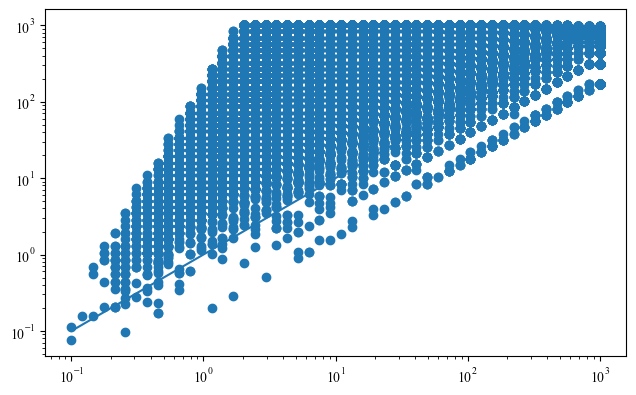

In [364]:
#Comparison of peak time and detectability interval

fil = (snr_O4 > 12) & (m_out > 0) & (grb_peak[:, 0, 0] > 0.01)
plt.scatter(grb_tpk[fil], deltat_ag[fil])
plt.xscale('log')
plt.yscale('log')
plt.plot(10 ** np.linspace(-1, 3, 100), 10 ** np.linspace(-1, 3, 100))

(0.001, 1)

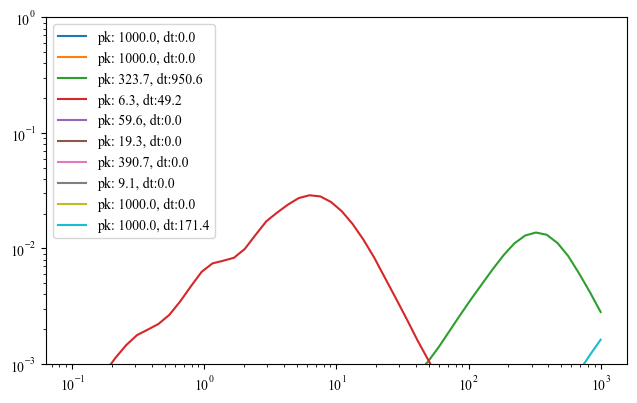

In [320]:
for i in range(50):
    if grb_tpk[i] <= 0.1:
        continue
    else:
        plt.plot(t_grb, lc_grb[i, 0, :, 0], label=f"pk: {grb_tpk[i]:.1f}, dt:{deltat_ag[i]:.1f}")
    
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.ylim([1.e-3, 1])

### Fig. 3 in countour plot

The countours are the events selected by GW + AG (blue) or GW + KN + AG (red). The oblique line has the same meaning as in Fig. 2, but for a tiling radio instrument.

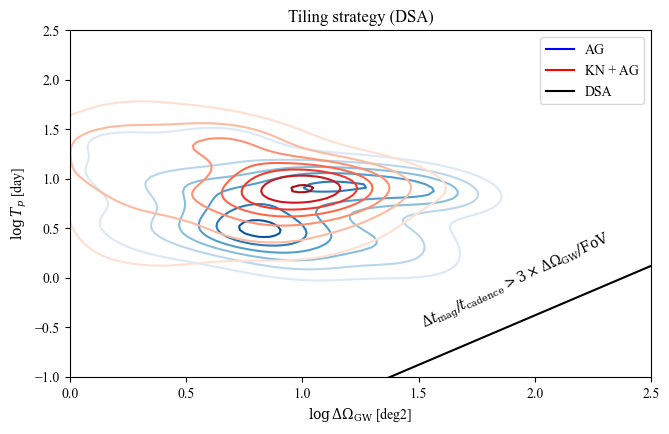

In [131]:
#### Fig. 3 ####
ymin = -1
ymax = 2.5
xmin = 0
xmax = 2.5
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

om_l = 10**np.linspace(xmin, xmax, 300)


fil = (snr_O4>12)&(m_out>0)

# AG
values = np.vstack([np.log10(sky_loc_LVKO4[fil]), np.log10(grb_tpk[fil])])
kernel = st.gaussian_kde(values, bw_method=0.40,
    weights=w[fil] * (grb_peak[:,0,0][fil] > dsa_tiling_lim)) 
f = np.reshape(kernel(positions).T, xx.shape)
plt.contour(xx, yy, f, cmap='Blues')
plt.plot(list(), list(), color='blue', label='AG')

# KN+AG
values = np.vstack([np.log10(sky_loc_LVKO4[fil]), np.log10(grb_tpk[fil])])
kernel = st.gaussian_kde(values, bw_method=0.40,
    weights=w[fil] * (grb_peak[:,0,0][fil] > dsa_tiling_lim) \
                   * ((mpk_g[fil] < gen_d['g']) | (mpk_z[fil] < gen_d['z']) | (mpk_J[fil] < gen_d['J']) ))
f = np.reshape(kernel(positions).T, xx.shape)
plt.contour(xx, yy, f, cmap='Reds')
plt.plot(list(), list(), color='red', label='KN + AG')

# DSA tiling
plt.plot(np.log10(om_l), np.log10(3 * dsa_tiling_cadence * om_l / dsa_tiling_fov), color='black', label='DSA')
plt.text(1.5, -0.5, r"$\Delta t_{\rm mag} / t_{\rm cadence} > 3 \times \Delta \Omega_{\rm GW} / {\rm FoV}$", color='black', rotation=25)

plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.ylabel(r'$\log T_p$ [day]')
plt.xlabel(r'$\log \Delta \Omega_{\rm GW}$ [deg2]')

plt.title('Tiling strategy (DSA)')
plt.legend()
#plt.savefig(f'plots/fig3.pdf', bbox_inches='tight')

In [99]:
(grb_tpk == 1.e3).sum()

36613

In [102]:
w[(m_out > 0) & (snr_O4 > 12) & (grb_tpk == 1.e3)].sum()

0.8169247944432658

In [103]:
w[(m_out > 0) & (snr_O4 > 12)].sum()

3.8286201545396823

In [231]:
prompt_det_fermi.shape

(1000000,)